# The COMPAS Project: A Computational Database of Polycyclic Aromatic Systems. Phase 2: _cata_-condensed Hetero-Polycyclic Aromatic Systems

## Library enumeration

## Summary
This Jupyter notebook contains details of the enumeration of the heterocyclic aromatic molecules. 

# Library enumeration

The molecule generation algorithm generates one molecule at a time by randomly choosing one of the rings as a seed and iteratively attaching a randomly chosen fragment using the RDKit's built-in SMARTS reaction engine. The probability of benzene being chosen was increased 10 fold to obtain more “realistic” molecules. The number of iterations is sampled from a quasi-Poisson distribution observed by a random algorithm that enumerates all possible combinations. 

In [1]:
import sys

from pathlib import Path

import numpy as np 

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem

import mols2grid

from utils import enumerate_library

%load_ext autoreload
%autoreload 2

DATA_FOLDER = Path('data')
FIGURE_FOLDER = Path('figures')

## Reaction SMARTS

SMARTS reactions lie at the core of the enumeration algorithm. They are a way to encode molecular transformations in a string. Reactions can be expressed in a general way using this format `reactant1.reactant2>conditions>product1.product2`. The molecules are represented using SMILES or SMARTS. SMARTS allow more strict rules than SMILES for reactant pattern matching. The atoms that are conserved from reactant to products are mapped using a numeric tag `[atom:number]`

We are interested in matching any pair of Carbon `[#6]` presented in only one ring `[R1]` (non-pericyclic) joined by any type `~` of bond (single, double or aromatic). `[#6;R1:1]~[#6;R1:2]`

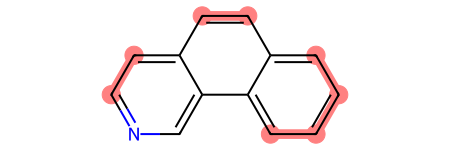

In [2]:
mol = Chem.MolFromSmiles("c1ccc2c(c1)ccc1ccncc21")
pattern = Chem.MolFromSmarts("[#6;R1:1]~[#6;R1:2]")
matches = mol.GetSubstructMatches(pattern)
mol

Eleven different reactions were used (see Figure 1 of main text). Each reaction attaches one of the fragments. The reaction is used for the attachment of a pyrrole ring. `[#6;R1:1]~[#6;R1:2]>>[c:2]:1:[c:5]:[c:4]:[n:3]([H]):[c:1]:1`

To adjust the probability of attaching a specific fragment the reactions were stored in a `list` where each reaction may appear more than once.

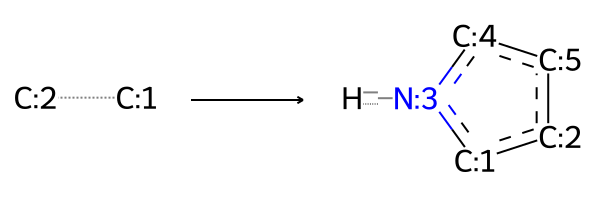

In [3]:
rxn = AllChem.ReactionFromSmarts("[#6;R1:1]~[#6;R1:2]>>[c:2]:1:[c:5]:[c:4]:[n:3]([H]):[c:1]:1")
Draw.ReactionToImage(rxn, subImgSize=(200,200))

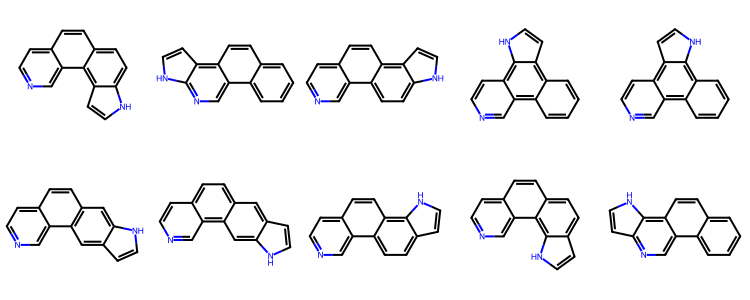

In [4]:
products = rxn.RunReactants([mol])

# RunReactants return a list of all the possible products
# on all the reaction centers that match the reactant pattern
# get_products unravel the list and filter out duplicates
unique_products = enumerate_library.get_products(products)

# align all the products to the reactant
AllChem.Compute2DCoords(mol)
for p in unique_products:
   _ = AllChem.GenerateDepictionMatching2DStructure(p,mol)

Draw.MolsToGridImage(unique_products, molsPerRow=5, subImgSize=(150,150),useSVG=True)

## Sampling the number of rings

The distribution is drawn from an inverted Poisson distribution. The goal is to sample more exhaustively the chemical space of the molecules with a ring size of 8 while still exploring the nearby space. However, due to computational resource limitations, it is required that bigger rings appear with less frequency in the dataset. 


<AxesSubplot: ylabel='Density'>

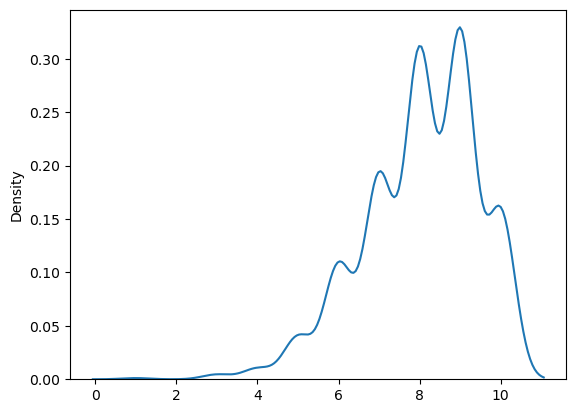

In [5]:
import numpy as np
import seaborn as sns

max_nRing = 10
mean_nRing = 8

n_rings = []

for i in range(10**3):
    n_ring = 0
    ep = max_nRing - mean_nRing
    while n_ring < 2: 
        x = np.random.poisson(ep)
        x = np.round(x, decimals = 0)
        n_ring = -x + max_nRing
        n_rings.append(n_ring)

sns.kdeplot(x=n_rings)
# sns.histplot(x=n_rings)

# Generate one molecule

The molecule generation algorithm yields one molecule at a time.

```python

n = get ring size
seq = select n random fragment
reactant = seq[0]
for fragment in seq[:1]
    select random reaction
    products = run reactant(reactant)
    reactant = select random product

```

There are 3 required inputs for the algorithm. A list of the reactions SMARTS, the SMILES of the building blocks and the code of each building blocks. All of them must be in the same order because they are converted into a dictionary. The cells below show how the enumeration algorithm is implemented using six building blocks as an example.

In [6]:
reactions_sma = [
    "[#6;R1:1]~[#6;R1:2]>>[c:1]1[c:2][c:4][c:3]1",    
    "[#6;R1:1]~[#6;R1:2]>>[c:2]:1:[c:5]:[c:4]:[n:3]([H]):[c:1]:1",    
    "[#6;R1:1]~[#6;R1:2]>>[#5;H0;a:6]:1:[#6:2]:[#6:1]:[#5;H0;a:3]:[#6:4]:[#6:5]:1",
    "[#6;R1:1]~[#6;R1:2]>>[c:2]:1:[c:1]:[n:3]:[c:4]:[c:5]:[n:6]:1",
    "[#6;R1:1]~[#6;R1:2]>>[c:2]:1:[c:1]:[c:3]:[c:4]:[c:5]:[c:6]:1",
]

fragments_smi = [
    "C1=CC=C1",
    "c1c[nH]cc1",
    "B1=CC=BC=C1",
    "c1cnccn1",
    "c1ccccc1",
]

fragments_code = [   
    "cyclobutadiene",
    "pyrrole",
    "14diborine",
    "pyrazine",
    "benzene",
    ]

fragments_dict = {code: Chem.MolFromSmiles(smi) for smi, code in zip(fragments_smi,fragments_code)}
reactions_dict = {code: AllChem.ReactionFromSmarts(sma) for sma, code in zip(reactions_sma,fragments_code)}

The first step of the algorithm is to generate a random sequence of the desired number of rings.

In [7]:
import random 

seq = random.choices(fragments_code, k=4)
seq

['cyclobutadiene', '14diborine', 'cyclobutadiene', 'benzene']

The first element `seq[0]` of the sequence is used as seed and then the rest of the fragment are subsequuently added to all positions available and then one is randomly choosen.

In [8]:
mol = fragments_dict[seq[0]]
for code in seq[1:]:
    rxn = reactions_dict[code]
    ps = rxn.RunReactants([mol])
    mols = enumerate_library.get_products(ps)
    # the 12diene filter is uused to filter out cummulunes
    mols = enumerate_library.filter_list(mols,filter_fn=[enumerate_library.filter_12diene], useSmiles=True)
    mol = random.choice(mols)
    

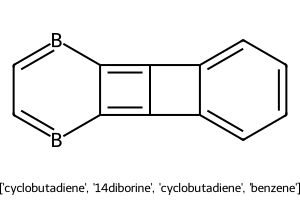

In [9]:
Draw.MolToImage(mol, legend=str(seq), size=(300,200))

The `enumerate_library.py` script was used to generate 600K molecules in batches of 50K. The following cells are an example of how to generate 500 molecules.


In [10]:
from tqdm import tqdm

mean_nRing = 8 
max_nRing = 10
nmols = 5*10**2

Builder = enumerate_library.PAHsBuilder(mean_nRing = mean_nRing,
                        max_nRing = max_nRing,
                        fragments = enumerate_library.FRAGMENTS_SMI,
                        reactions = enumerate_library.REACTIONS_SMA,
                        fragments_code = enumerate_library.FRAGMENTS_CODE)

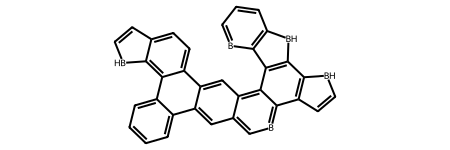

In [11]:
Builder.generate_mol()

In [12]:
pbar = tqdm(total=nmols) # Init pbar

mols = []
for i in range(nmols):
    pbar.update(n=1)
    mols.append(Builder.generate_mol())

100%|█████████▉| 498/500 [00:28<00:00, 21.89it/s]

In [13]:
mols2grid.display(mols)

MolGridWidget()

100%|██████████| 500/500 [00:40<00:00, 21.89it/s]